In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate


# Neural Network 
from sklearn.feature_selection import RFECV    # for feature selection 

# Load in training and test data

In [71]:
df = pd.read_csv("data/train.csv")
df.columns = list(df.columns.values)
df_test = pd.read_csv("data/test.csv")
df_test.columns = list(df_test.columns.values)

# Adding Additional Variables
Result: These indicator variables definitely worsen the performance of Logistic Regression. 

In [51]:
# ADD (bid volumes / ask volumes) ratio  TO TRAIN AND TEST 
# indicator - ratio of all bid volumes to all ask volumes
df_test = df_test.assign(bid_ask_ratio_all = \
                        lambda x: (x.bid1vol+x.bid2vol+x.bid3vol+x.bid4vol+x.bid5vol) / \
                                  (x.ask1vol+x.ask2vol+x.ask3vol+x.ask4vol+x.ask5vol))

# indicator - ratio of all bid volumes to all ask volumes
df = df.assign(bid_ask_ratio_all = \
                        lambda x: (x.bid1vol+x.bid2vol+x.bid3vol+x.bid4vol+x.bid5vol) / \
                                  (x.ask1vol+x.ask2vol+x.ask3vol+x.ask4vol+x.ask5vol))


# Add (best bid volume / best ask volume) TO TRAIN AND TEST 
# indicator - ratio of best bid (bid1) volume to best ask (ask1) volume

#df_test = df_test.assign(bid_ask_ratio_best = lambda x: x.bid1vol / x.ask1vol)
#df = df.assign(bid_ask_ratio_best = lambda x: x.bid1vol / x.ask1vol)


# indicator - difference between the price of most recent order and average of best bid and best ask (mid)
#df_test = df_test.assign(diff_price = lambda x: (x.last_price) - (x.mid))
#df = df.assign(diff_price = lambda x: (x.last_price) - (x.mid))

# indicator - difference between best bid price and best ask price
#df_test = df_test.assign(diff_best_bid_ask = lambda x: (x.bid1) - (x.ask1))
#df = df.assign(diff_best_bid_ask = lambda x: (x.bid1) - (x.ask1))


In [58]:
# Let's drop [bid2, ... bid5, ask2, ... ask5] columns due to heavy correlation 
df.drop(columns=['bid1vol','bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol','ask2vol',\
                 'ask3vol', 'ask4vol', 'ask5vol'], inplace=True)
df_test.drop(columns=['bid1vol','bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol','ask2vol',\
                 'ask3vol', 'ask4vol', 'ask5vol'], inplace=True)

# Dropping Highly Correlated Variables 

In [72]:

df.drop(columns=['closed_position_qty', 'opened_position_qty '], inplace=True)
df_test.drop(columns=['closed_position_qty', 'opened_position_qty '], inplace=True)

# Let's drop [bid2, ... bid5, ask2, ... ask5] columns due to heavy correlation 
df.drop(columns=['bid2', 'bid3', 'bid4', 'bid5', 'ask2', 'ask3', \
                 'ask4', 'ask5'], inplace=True)
df_test.drop(columns=['bid2', 'bid3', 'bid4', 'bid5', 'ask2', 'ask3', \
                 'ask4', 'ask5'], inplace=True)



In [73]:
df.head()

,id,last_price,mid,transacted_qty,d_open_interest,bid1,ask1,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
0,0,3842.4,3842.6,103.0,0,3842.4,3842.8,8,1,6,14,6,6,1,1,10,2,1
1,1,3842.8,3843.4,55.0,-43,3843.0,3843.8,7,6,11,1,6,1,4,4,1,13,0
2,2,3844.0,3844.3,84.0,-69,3843.8,3844.8,3,1,4,21,12,1,16,10,4,9,0
3,3,3843.8,3843.4,37.0,-30,3843.0,3843.8,10,13,12,2,4,2,7,1,2,11,1
4,4,3843.2,3843.1,41.0,-35,3842.8,3843.4,14,12,2,2,4,1,3,1,11,15,1


# Separate data into X and y, Normalize 

In [74]:
# Separating into X and y training 
last_idx = len(df.columns) - 1
X = df[df.columns[:-1]]
#y_train = df[df.columns[last_idx]]
y_train = df.y
X = np.array(X)
y_train = np.array(y_train)
X_test = df_test
X_test = np.array(X_test)

# HANDLING IDs FOR TRAINING 
X_ids = X[:, 0]  # Vector of id's 
X = X[:, 1:]
# HANDLING IDs for TEST
X_test_ids = X_test[:, 0]
X_test = X_test[:, 1:]

# Normalize test set features using training set stats
for j in range(0,len(X_test[0])):
    X_std = np.std(X[:, j])
    X_test[:, j] -= np.mean(X[:, j])
    X_test[:, j] *= (1 / X_std)

# Normalize training set features 
for j in range(0,len(X[0])):
    X_std = np.std(X[:, j])
    X[:, j] -= np.mean(X[:, j])
    X[:, j] *= (1 / X_std)

# Logistic Reg (no regularization)

In [75]:
# Let's try logistic regression for different lambda = 0.00001,
# 0.00005, 0.00025, 61, 035.15625
lam = 0.0005 # Penalizing to take care of some strong correlation between features  
# C is inverse of regularization strength 

#base = np.repeat(5, 5)
#power = np.arange(0, 5)
#lambdas = np.power(base, power)
#final_lambdas = 0.00001 * lambdas

# The C's (inv regularization strength) range from 1e-5 ... 1e5
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X, y_train)
#clf = LogisticRegression(penalty='l2', C=(1/lam)).fit(X, y_trai )
y_pred = clf.predict_proba(X)
y_pred = y_pred[:,1]    # Grabbing probabililities of being in class 1


# Predicting on test set 
y_pred_test = clf.predict_proba(X_test)
y_pred_test = y_pred_test[:,1]  

# Test AUC-ROC score 

In [76]:
scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

#clf_test = RandomForestClassifier(max_depth=5, min_samples_split=2, 
                                 # random_state=0, n_estimators=10, 
                                 # max_features='sqrt', criterion='gini')

results = cross_validate(clf, X, y_train, cv=5, scoring=list(scoring.values()), 
                         return_train_score=False)
    
print('\nK-fold cross-validation results: ')
for sc in range(len(scoring)):
    print(clf.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
    if list(scoring.values())[sc]=='neg_log_loss' 
    else results['test_%s' % list(scoring.values())[sc]].mean(), 
        results['test_%s' % list(scoring.values())[sc]].std()))


K-fold cross-validation results: 
LogisticRegressionCV average accuracy: 0.651 (+/-0.001)
LogisticRegressionCV average log_loss: 0.628 (+/-0.002)
LogisticRegressionCV average auc: 0.639 (+/-0.006)


Best logistic regression model: no regularization, all columns except closed_position_qty
and opened_position_qty, [ask2, ... ask5], [bid2, ... bid5] with 5-fold stratified 
cross-validation achieves a score of 0.60549. 

# Artificial Neural Network 

In [1]:
import pandas as pd

# Preparing Dataset for ANN training 

In [16]:
df = pd.read_csv("data/train.csv")
df.columns = list(df.columns.values)
df_test = pd.read_csv("data/test.csv")
df_test.columns = list(df_test.columns.values)

In [17]:
df_test.columns = ['id', 'last_price', 'mid', 'opened_position_qty',
       'closed_position_qty', 'transacted_qty', 'd_open_interest', 'bid1',
       'bid2', 'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5',
       'bid1vol', 'bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol',
       'ask2vol', 'ask3vol', 'ask4vol', 'ask5vol']
df.columns = ['id', 'last_price', 'mid', 'opened_position_qty',
       'closed_position_qty', 'transacted_qty', 'd_open_interest', 'bid1',
       'bid2', 'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5',
       'bid1vol', 'bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol',
       'ask2vol', 'ask3vol', 'ask4vol', 'ask5vol', 'y']

# Non-stationary : 

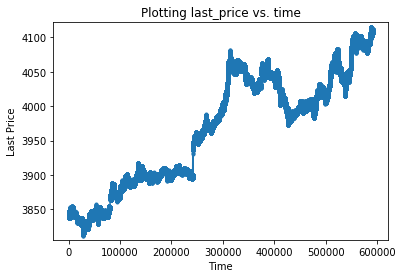

In [19]:
fig = plt.figure()
plt.title('Plotting last_price vs. time')
plt.xlabel('Time')
plt.ylabel('Last Price')
plt.margins(y=0.02)

plt.plot(df["id"], df["last_price"], marker = '.', linewidth = 1.5)

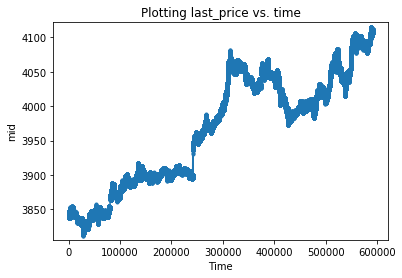

In [20]:
fig = plt.figure()
plt.title('Plotting last_price vs. time')
plt.xlabel('Time')
plt.ylabel('mid')
plt.margins(y=0.02)

plt.plot(df["id"], df["last_price"], marker = '.', linewidth = 1.5)

In this limited dataset, it appears that mid price does not fluctuate about some mean with a constant variance (as a stationary time-series would), but rather showcases characteristics 

In [8]:
# Using Betty's preprocessing code and final features (from a day ago)
# Filling NaN values 
nan_values = {'opened_position_qty': (df['transacted_qty'] + df['d_open_interest']) / 2 , 
              'closed_position_qty': (df['transacted_qty'] - df['d_open_interest']) / 2}

nan_values_test = {'opened_position_qty': (df_test['transacted_qty'] + df_test['d_open_interest']) / 2 , 
              'closed_position_qty': (df_test['transacted_qty'] - df_test['d_open_interest']) / 2}

df = df.fillna(value=nan_values)
df_test = df_test.fillna(value=nan_values_test)




# ADD (bid volumes / ask volumes) ratio  TO TRAIN AND TEST 
# indicator - ratio of all bid volumes to all ask volumes
df_test = df_test.assign(bid_ask_ratio_all = \
                        lambda x: (x.bid1vol+x.bid2vol+x.bid3vol+x.bid4vol+x.bid5vol) / \
                                  (x.ask1vol+x.ask2vol+x.ask3vol+x.ask4vol+x.ask5vol))

# indicator - ratio of all bid volumes to all ask volumes
df = df.assign(bid_ask_ratio_all = \
                        lambda x: (x.bid1vol+x.bid2vol+x.bid3vol+x.bid4vol+x.bid5vol) / \
                                  (x.ask1vol+x.ask2vol+x.ask3vol+x.ask4vol+x.ask5vol))


# Add (best bid volume / best ask volume) TO TRAIN AND TEST 
# indicator - ratio of best bid (bid1) volume to best ask (ask1) volume

df_test = df_test.assign(bid_ask_ratio_best = lambda x: x.bid1vol / x.ask1vol)
df = df.assign(bid_ask_ratio_best = lambda x: x.bid1vol / x.ask1vol)


# indicator - difference between the price of most recent order and average of best bid and best ask (mid)
df_test = df_test.assign(diff_price = lambda x: (x.last_price) - (x.mid))
df = df.assign(diff_price = lambda x: (x.last_price) - (x.mid))

# indicator - difference between best bid price and best ask price
df_test = df_test.assign(diff_best_bid_ask = lambda x: (x.bid1) - (x.ask1))
df = df.assign(diff_best_bid_ask = lambda x: (x.bid1) - (x.ask1))


# Inserting additional indicators into train and test 

# 12 Features: Selected features: ['mid', 'transacted_qty', 'bid1vol', 'ask1vol', 'value', 'diff_price',
# 'diff_best_bid_ask', 'openclosed', 'diff_bid_ask2', 'sm2', 'sm3', 'sm4']

# open - closed 
df = df.assign(openclosed = lambda x: x.opened_position_qty - x.closed_position_qty)
df_test = df_test.assign(openclosed = lambda x: x.opened_position_qty - x.closed_position_qty)

# dif_bid_ask2
df = df.assign(diff_bid_ask2 = lambda x: (x.bid1+ x.bid2) - (x.ask1+x.ask2))
df_test = df_test.assign(diff_bid_ask2 = lambda x: (x.bid1+ x.bid2) - (x.ask1+x.ask2))

# value
df = df.assign(value = lambda x: x.bid1vol - x.ask1vol)
df_test = df_test.assign(value = lambda x: x.bid1vol - x.ask1vol)


# sm2, sm3, sm4
df = df.assign(sm4 = lambda x: (x.bid1vol+ x.bid2vol+x.bid3vol+x.bid4vol) - (x.ask1vol+x.ask2vol+x.ask3vol+x.ask4vol))
df = df.assign(sm3 = lambda x: (x.bid1vol+ x.bid2vol+x.bid3vol) - (x.ask1vol+x.ask2vol+x.ask3vol))
df = df.assign(sm2 = lambda x: (x.bid1vol+ x.bid2vol) - (x.ask1vol+x.ask2vol))

df_test = df_test.assign(sm4 = lambda x: (x.bid1vol+ x.bid2vol+x.bid3vol+x.bid4vol) - (x.ask1vol+x.ask2vol+x.ask3vol+x.ask4vol))
df_test = df_test.assign(sm3 = lambda x: (x.bid1vol+ x.bid2vol+x.bid3vol) - (x.ask1vol+x.ask2vol+x.ask3vol))
df_test = df_test.assign(sm2 = lambda x: (x.bid1vol+ x.bid2vol) - (x.ask1vol+x.ask2vol))


cols1 = ['last_price', 
        'transacted_qty', 'd_open_interest', 
        'bid_ask_ratio_all', 'bid_ask_ratio_best', 
        'diff_price', 'diff_best_bid_ask']        # Option 1

cols2 = ['mid', 'transacted_qty', 'bid1vol', 'ask1vol', 'value', 'diff_price',
 'diff_best_bid_ask', 'openclosed', 'diff_bid_ask2', 'sm2', 'sm3', 'sm4']

cols = cols2   # deciding which features to use 

X = np.asarray(df[cols])
y_train = np.asarray(df['y'])

X_test = np.asarray(df_test[cols])  # grabbing test set 


# Normalize test set features using training set stats
for j in range(0,len(X_test[0])):
    X_std = np.std(X[:, j])
    X_test[:, j] -= np.mean(X[:, j])
    X_test[:, j] *= (1 / X_std)

# Normalize training set features 
for j in range(0,len(X[0])):
    X_std = np.std(X[:, j])
    X[:, j] -= np.mean(X[:, j])
    X[:, j] *= (1 / X_std)

# Adding indicators 
# indicator - ratio of all bid volumes to all ask volumes
#df_ex = df.assign(bid_ask_ratio_all = \
                     #   lambda x: (x.bid1vol+x.bid2vol+x.bid3vol+x.bid4vol+x.bid5vol) / \
                       #           (x.ask1vol+x.ask2vol+x.ask3vol+x.ask4vol+x.ask5vol))
# indicator - ratio of best bid (bid1) volume to best ask (bid2) volume
#df_ex = df_ex.assign(bid_ask_ratio_best = lambda x: x.bid1vol / x.ask1vol)

# indicator - difference between the price of most recent order and average of best bid and best ask (mid)
#df_ex = df_ex.assign(diff_price = lambda x: (x.last_price) - (x.mid))

# indicator - difference between best bid price and best ask price
#df_ex = df_ex.assign(diff_best_bid_ask = lambda x: (x.bid1) - (x.ask1))
#cols = ['last_price', 
    #    'transacted_qty', 'd_open_interest', 
     #   'bid_ask_ratio_all', 'bid_ask_ratio_best', 
      #  'diff_price', 'diff_best_bid_ask']

#X = np.asarray(df_ex[cols])
#y_train = np.asarray(df_ex['y'])

In [9]:
# Try decorrelating the data (apply some transformation to make data stationary 
# time series)
df_test.isna().any()

id                     False
last_price             False
mid                    False
opened_position_qty    False
closed_position_qty    False
transacted_qty         False
d_open_interest        False
bid1                   False
bid2                   False
bid3                   False
bid4                   False
bid5                   False
ask1                   False
ask2                   False
ask3                   False
ask4                   False
ask5                   False
bid1vol                False
bid2vol                False
bid3vol                False
bid4vol                False
bid5vol                False
ask1vol                False
ask2vol                False
ask3vol                False
ask4vol                False
ask5vol                False
bid_ask_ratio_all      False
bid_ask_ratio_best     False
diff_price             False
diff_best_bid_ask      False
openclosed             False
diff_bid_ask2          False
value                  False
sm4           

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV 
from keras.wrappers.scikit_learn import KerasClassifier 

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
model = Sequential()
model.add(Dense(7,input_dim=12, activation='relu'))# Input layer, size (,7)
model.add(Dropout(0.18))
model.add(Dense(7, activation='relu'))
model.add(Dropout(0.18))
model.add(Dense(1, activation='sigmoid'))  # Output probability of midprice 
                                           # going up. 
    
model.compile(optimizer='adam', loss='binary_crossentropy', \
             metrics=['accuracy'])

In [28]:
model.fit(X, y_train, epochs=10, batch_size=64)
y_pred = model.predict(X_test)

Epoch 1/10
592380/592380 [==============================] - 8s 13us/step - loss: 0.6302 - acc: 0.6430
Epoch 2/10
592380/592380 [==============================] - 8s 14us/step - loss: 0.6234 - acc: 0.6434
Epoch 3/10
592380/592380 [==============================] - 9s 14us/step - loss: 0.6227 - acc: 0.6477
Epoch 4/10
592380/592380 [==============================] - 9s 14us/step - loss: 0.6224 - acc: 0.6518
Epoch 5/10
592380/592380 [==============================] - 9s 15us/step - loss: 0.6224 - acc: 0.6514
Epoch 6/10
592380/592380 [==============================] - 9s 15us/step - loss: 0.6223 - acc: 0.6543
Epoch 7/10
592380/592380 [==============================] - 9s 15us/step - loss: 0.6225 - acc: 0.6521
Epoch 8/10
592380/592380 [==============================] - 9s 15us/step - loss: 0.6222 - acc: 0.6556
Epoch 9/10
592380/592380 [==============================] - 9s 15us/step - loss: 0.6224 - acc: 0.6547
Epoch 10/10
592380/592380 [==============================] - 9s 15us/step - loss: 

In [51]:
y_pred_train = model.predict(X)

In [12]:
# Let's try some gridsearch 
def build_model(optimizer):
    model = Sequential()
    model.add(Dense(7,input_dim=12, activation='relu'))# Input layer, size (,7)
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))  # Output probability of midprice 
                                           # going up.
    model.compile(optimizer='adam', loss='binary_crossentropy', \
             metrics=['accuracy'])
    return model 
model = KerasClassifier(build_fn = build_model)
parameters = {'batch_size': [64], 
             'nb_epoch':[10],
                 'optimizer': ['adam', 'rmsprop', 'Adagrad']}
grid_search = GridSearchCV(estimator=model, param_grid=parameters,
                          scoring='accuracy', cv=10)
grid_search = grid_search.fit(X, y_train)
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

Epoch 1/1
533142/533142 [==============================] - 7s 13us/step - loss: 0.6249 - acc: 0.6521
Epoch 1/1
533142/533142 [==============================] - 7s 13us/step - loss: 0.6316 - acc: 0.6406
Epoch 1/1
533142/533142 [==============================] - 7s 14us/step - loss: 0.6264 - acc: 0.6526
Epoch 1/1
533142/533142 [==============================] - 8s 14us/step - loss: 0.6281 - acc: 0.6506
Epoch 1/1
533142/533142 [==============================] - 8s 15us/step - loss: 0.6273 - acc: 0.6512
Epoch 1/1
533142/533142 [==============================] - 8s 15us/step - loss: 0.6293 - acc: 0.6509
Epoch 1/1
533142/533142 [==============================] - 8s 15us/step - loss: 0.6266 - acc: 0.6500
Epoch 1/1
533142/533142 [==============================] - 8s 16us/step - loss: 0.6269 - acc: 0.6495
Epoch 1/1
533142/533142 [==============================] - 8s 16us/step - loss: 0.6265 - acc: 0.6528
Epoch 1/1
533142/533142 [==============================] - 8s 16us/step - loss: 0.6226 - ac

In [33]:
best_params

{'batch_size': 64, 'nb_epoch': 10, 'optimizer': 'Adagrad'}

In [34]:
best_accuracy

0.6590161720517236

In [37]:
# Let's shuffle the training data to try to mimic shuffling in test 
# and avoid pushing the ANN weights in one direction 
idx = np.arange(0, len(X))
perm_idx = np.random.permutation(idx)
X = X[perm_idx]
y_train = y_train[perm_idx]

In [39]:
perm_idx

array([158225, 529544, 324274, ...,   7607, 297583, 509218])

In [8]:
model = Sequential()
model.add(Dense(7,input_dim=12, activation='relu'))# Input layer, size (,7)
model.add(Dropout(0.2))
model.add(Dense(7, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Output probability of midprice 
                                           # going up. 
    
model.compile(optimizer='Adagrad', loss='binary_crossentropy', \
             metrics=['accuracy'])
model.fit(X, y_train, epochs=10, batch_size=64, shuffle=True)
y_pred = model.predict(X_test)

Epoch 1/10
592380/592380 [==============================] - 6s 11us/step - loss: 0.6357 - acc: 0.6418
Epoch 2/10
592380/592380 [==============================] - 6s 10us/step - loss: 0.6310 - acc: 0.6449
Epoch 3/10
592380/592380 [==============================] - 6s 11us/step - loss: 0.6297 - acc: 0.6459
Epoch 4/10
592380/592380 [==============================] - 6s 11us/step - loss: 0.6287 - acc: 0.6469
Epoch 5/10
592380/592380 [==============================] - 7s 11us/step - loss: 0.6284 - acc: 0.6471
Epoch 6/10
592380/592380 [==============================] - 7s 11us/step - loss: 0.6281 - acc: 0.6475
Epoch 7/10
592380/592380 [==============================] - 7s 12us/step - loss: 0.6276 - acc: 0.6478
Epoch 8/10
592380/592380 [==============================] - 7s 12us/step - loss: 0.6275 - acc: 0.6476
Epoch 9/10
592380/592380 [==============================] - 7s 12us/step - loss: 0.6271 - acc: 0.6496
Epoch 10/10
592380/592380 [==============================] - 7s 12us/step - loss: 

In [10]:
y_train_pred = model.predict(X)

# Outputting Results to CSV

In [12]:
#y_pred[:10]
roc_auc_score(y_train, y_train_pred)

0.6488576302915351

In [13]:
# fix output format
X_test_ids = list(df_test['id'].astype(int))
#X_test_ids = df['id'].astype(int)
y_pred_flat = np.ndarray.flatten(y_pred)
predictions = {'id': X_test_ids, 'Predicted': y_pred_flat}
df_output = pd.DataFrame(predictions, columns=['id', 'Predicted'])
df_output.set_index('id')
df_output.to_csv('ANN_dropout_3.csv', index=None)

In [37]:
cols = ['id', 'Predicted']
df_output = df_output[cols]

In [30]:
np.ndarray.flatten(y_pred)

array([0.67061865, 0.61808383, 0.48727542, ..., 0.65179896, 0.621622  ,
       0.66336346], dtype=float32)

In [14]:
df_output.head()

,id,Predicted
0,592380,0.476167
1,592381,0.324176
2,592382,0.344855
3,592383,0.476167
4,592384,0.405700


In [44]:
X_test_ids = list(df_test['id'])

In [46]:
X_test_ids[:10]

[592380,
 592381,
 592382,
 592383,
 592384,
 592385,
 592386,
 592387,
 592388,
 592389]

In [15]:
test = '12345'
"{0}\t{1}".format(1, test)

'1\t12345'

In [21]:
a = None
b = ''
if a == b:
    print("hi")